<b>NOTE</b>:<br> This notebook is my understanding of chapter 11 of `Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow 2nd Edition` book written by `Aurelien Geron`, entitled as `Training Deep Neural Networks`.<br>
While most of the markdowns and code blocks have been copied from the chapter's notebook, the arraingment and changes made to the whole project is personalized based on my knowledge and what I comprehended and learned from the book. I'm going to use this notebook as a reference, when I want to apply Deep Neural Network on Machine Learning projects in the future.

`Aurelien Geron`'s Github repository for the book can be found [here](https://github.com/ageron/handson-ml2).

# Objective

In this chapter, we will go through some of deep learning problems in turn and present techniques to solve them. We will start by explaining the vanishing gradients problem and exploring some of the most popular solutions to this problem. Next, we will look at transfer learning and unsupervised pretraining, which can help you tackle complex tasks even when you have little labeled data. Then we will discuss various optimizers that can speed up training large models tremendously compared to plain Gradient Descent. Finally, we will go through a few popular regularization techniques for large neural networks.
With these tools, you will be able to train very deep nets: welcome to Deep Learning!

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

# Vanishing/Exploding Gradients Problems

As we know, the backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each
parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.<br>

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good
solution. This is called the <b>vanishing gradients</b> problem.<br>

In some cases, the opposite can happen. Meaning the gradients can grow bigger and bigger, so many layers get insanely
large weight updates and the algorithm diverges. This is the <b>exploding gradients</b> problem, which is mostly encountered in recurrent neural networks.<br>

More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.<br>

# Activation Function:

The activation function is a mathematical gate between the input of a neuron and its output. It decides what to output, based on a set of rules it applies to the weighted sum of inputs.

## Logistic activation function

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

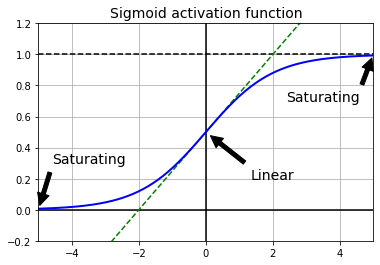

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

Looking at the logistic activation function (sigmoid), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus when backpropagation kicks in, it has virtually
no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

The solution is that the connection weights of each layer must be initialized randomly as `fan-avg = (fan-in + fan-out)/2`, where fan-in is the number of inputs of a layer, and fan-out is the number of output of that layer. This initialization strategy is called Glorot initialization.

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

This is how we can change the initilization strategy while creating a layer:

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

# Nonsaturating Activation Functions

It turns out that other activation functions behave much better that logistic activation functions in deep neural networks, in particular the ReLU activation function, mostly because it does not saturate for positive values (and also because it is quite fast to compute).<br>

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the <b>dying ReLUs</b>: during training, some neurons effectively die, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting 0s, and gradient descent does not affect it anymore since the gradient of the ReLU function is 0 when its input is negative.<br>

### Leaky ReLU

To solve the dying ReLUs problem, you may want to use a variant of the ReLU function, such as the <b>leaky ReLU</b>. This function is defined as LeakyReLUα(z) = max(αz, z). The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0, and is typically set to 0.01. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. A 2015 paper compared several variants of the ReLU activation function and one of its conclusions was that the leaky variants always outperformed the strict ReLU activation function. In fact, setting α = 0.2 (huge leak) seemed to result in better performance than α = 0.01 (small leak). They also evaluated the randomized leaky ReLU (RReLU), where α is picked randomly in a given range during training, and it is fixed to an average value during testing. It also performed fairly well and seemed to act as a regularizer (reducing the risk of overfitting the training set).

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

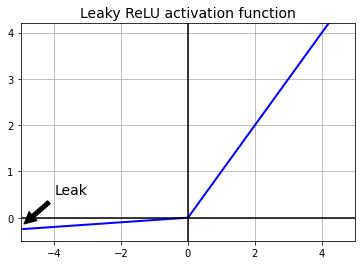

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

As can be seen, leaky ReLU can't be found in keras.activations. We have it as a keras.layer instead:

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

In [12]:
(train_set_X_full, train_set_Y_full), (test_set_X, test_set_Y) = keras.datasets.fashion_mnist.load_data()
train_set_X_full = train_set_X_full / 255.0
test_set_X = test_set_X / 255.0
valid_set_X, train_set_X = train_set_X_full[:5000], train_set_X_full[5000:]
valid_set_Y, train_set_Y = train_set_Y_full[:5000], train_set_Y_full[5000:]

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(train_set_X, train_set_Y,
                    epochs=10,
                    validation_data=(valid_set_X, valid_set_Y))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.6314 - accuracy: 0.5054 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8416 - accuracy: 0.7247 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7053 - accuracy: 0.7637 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6325 - accuracy: 0.7908 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5992 - accuracy: 0.8021 - val_loss: 0.5582 - val_accuracy: 0.8198
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5624 - accuracy: 0.8142 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5379 - accuracy: 0.8218 - val_loss: 0.5156 - val_accuracy:

### ELU

<b>Exponential linear unit (ELU)</b> looks a lot like the ReLU function, with a few major differences:<br>

• First it takes on negative values when z < 0, which allows the unit to have an average output closer to 0. This helps alleviate the vanishing gradients problem, as discussed earlier. The hyperparameter α defines the value that the ELU function
approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter if you want.<br>

• Second, it has a nonzero gradient for z < 0, which avoids the dead neurons problem.<br>

• Third, if α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent, since it does not bounce as much left and right of z = 0.<br>

The main drawback of the ELU activation function is that it is slower to compute than the ReLU and its variants (due to the use of the exponential function), but during training this is compensated by the faster convergence rate. However, at test time
an ELU network will be slower than a ReLU network.

In [16]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

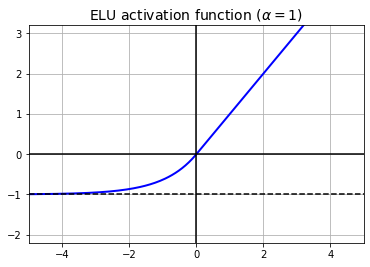

In [17]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu"),
    keras.layers.Dense(100, activation="elu"),
    keras.layers.Dense(10, activation="softmax")
])

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [20]:
history = model.fit(train_set_X, train_set_Y,
                    epochs=10,
                    validation_data=(valid_set_X, valid_set_Y))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.4762 - accuracy: 0.5483 - val_loss: 0.8035 - val_accuracy: 0.7408
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7773 - accuracy: 0.7456 - val_loss: 0.6665 - val_accuracy: 0.7828
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6650 - accuracy: 0.7784 - val_loss: 0.6104 - val_accuracy: 0.8002
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6060 - accuracy: 0.7995 - val_loss: 0.5666 - val_accuracy: 0.8100
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5789 - accuracy: 0.8053 - val_loss: 0.5397 - val_accuracy: 0.8176
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5472 - accuracy: 0.8145 - val_loss: 0.5202 - val_accuracy: 0.8226
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5266 - accuracy: 0.8196 - val_loss: 0.5043 - val_accuracy:

### SELU

<b>Scaled version of ELU (SELU)</b> activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

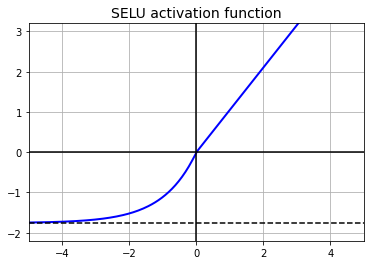

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [27]:
pixel_means = train_set_X.mean(axis=0, keepdims=True)
pixel_stds = train_set_X.std(axis=0, keepdims=True)
train_set_X_scaled = (train_set_X - pixel_means) / pixel_stds
valid_set_X_scaled = (valid_set_X - pixel_means) / pixel_stds
test_set_X_scaled = (test_set_X - pixel_means) / pixel_stds

In [28]:
history = model.fit(train_set_X_scaled, train_set_Y,
                    epochs=5,
                    validation_data=(valid_set_X_scaled, valid_set_Y))

Epoch 1/5
1719/1719 [==============================] - 36s 19ms/step - loss: 1.3906 - accuracy: 0.4592 - val_loss: 0.7322 - val_accuracy: 0.7440
Epoch 2/5
1719/1719 [==============================] - 37s 21ms/step - loss: 0.6896 - accuracy: 0.7526 - val_loss: 0.6524 - val_accuracy: 0.7696
Epoch 3/5
1719/1719 [==============================] - 30s 18ms/step - loss: 0.5689 - accuracy: 0.8008 - val_loss: 0.5594 - val_accuracy: 0.7982
Epoch 4/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.5811 - accuracy: 0.8027 - val_loss: 0.4854 - val_accuracy: 0.8346
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.5068 - accuracy: 0.8239 - val_loss: 0.4546 - val_accuracy: 0.8454


Now look at what happens if we try to use the ReLU activation function on scaled train and valid asets instead:

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [32]:
history = model.fit(train_set_X_scaled, train_set_Y,
                    epochs=5,
                    validation_data=(valid_set_X_scaled, valid_set_Y))

Epoch 1/5
1719/1719 [==============================] - 24s 13ms/step - loss: 2.0875 - accuracy: 0.1791 - val_loss: 1.4671 - val_accuracy: 0.3808
Epoch 2/5
1719/1719 [==============================] - 23s 13ms/step - loss: 1.3122 - accuracy: 0.4300 - val_loss: 1.0152 - val_accuracy: 0.5714
Epoch 3/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.0237 - accuracy: 0.5732 - val_loss: 0.9137 - val_accuracy: 0.5864
Epoch 4/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.8591 - accuracy: 0.6500 - val_loss: 0.7524 - val_accuracy: 0.7178
Epoch 5/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.8111 - accuracy: 0.6780 - val_loss: 0.6833 - val_accuracy: 0.7482


Not great at all, we suffered from the vanishing/exploding gradients problem.

### PReLU

Finally, they also evaluated the <b>parametric leaky ReLU (PReLU)</b>, where α is authorized
to be learned during training (instead of being a hyperparameter, it becomes a
parameter that can be modified by backpropagation like any other parameter). This
was reported to strongly outperform ReLU on large image datasets, but on smaller
datasets it runs the risk of overfitting the training set.

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

In [34]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [36]:
history = model.fit(train_set_X, train_set_Y,
                    epochs=10,
                    validation_data=(valid_set_X, valid_set_Y))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6969 - accuracy: 0.4974 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8706 - accuracy: 0.7247 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7211 - accuracy: 0.7620 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6448 - accuracy: 0.7881 - val_loss: 0.6004 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6078 - accuracy: 0.8004 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5693 - accuracy: 0.8118 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5428 - accuracy: 0.8193 - val_loss: 0.5196 - val_accuracy:

# Choosing an Activation Function For Hidden Layers

So which activation function should you use for the hidden layersvof your deep neural networks?<br>
Although your mileage will vary, in general<br>

`SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic`<br>

If the network’s architecture prevents it from self-normalizing, then ELU may perform better than SELU (since SELU is not smooth at z = 0). If you care a lot about runtime latency, then you may prefer leaky ReLU. If you don’t want to tweak yet another
hyperparameter, you may just use the default α values used by Keras (e.g., 0.3 for the leaky ReLU). If you have spare time and
computing power, you can use cross-validation to evaluate other activation functions, in particular RReLU if your network is overfitting, or PReLU if you have a huge training set.

# Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.
<b>Batch Normalization (BN)</b> is a technique to address the vanishing/exploding gradients problems.
The technique consists of adding an operation in the model just before or after the activation function of each hidden layer, simply zero-centering and normalizing each input, then scaling and shifting the result using four new parameter.<br>

Four parameter vectors which are learned in each batch-normalized
layer are:<br>
γ (the ouput scale vector)<br>
β (the output offset vector) are learned through regular backpropagation<br>
μ (the final input mean vector)<br>
σ (the final input standard deviation vector) are estimated using an exponential moving average.<br>

Note that μ and σ are estimated during training, but they are not used at all during training,
only after training (to replace the batch input means and standard deviations).<br>

In other words, this operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler): the BN layer will do it for you.

In [37]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_213 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_214 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_215 (Dense)            (None, 10)               

Each BN layer adds 4 parameters per input: γ, β, μ and σ (for example, the first BN layer adds 3136 parameters, which is 4 times 784). The last two parameters, μ and σ, are the moving averages, they are not affected by backpropagation, so Keras calls them “Nontrainable” (if you count the total number of BN parameters, 3136 + 1200 + 400, and divide by two, you get 2,368, which is the total number of non-trainable params in this model).

In [39]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [40]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [41]:
history = model.fit(train_set_X, train_set_Y,
                    epochs=10,
                    validation_data=(valid_set_X, valid_set_Y))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.1207 - accuracy: 0.6292 - val_loss: 0.5539 - val_accuracy: 0.8160
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5954 - accuracy: 0.7947 - val_loss: 0.4792 - val_accuracy: 0.8378
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5296 - accuracy: 0.8168 - val_loss: 0.4424 - val_accuracy: 0.8494
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4855 - accuracy: 0.8301 - val_loss: 0.4212 - val_accuracy: 0.8570
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4683 - accuracy: 0.8354 - val_loss: 0.4051 - val_accuracy: 0.8616
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4399 - accuracy: 0.8435 - val_loss: 0.3931 - val_accuracy: 0.8634
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4263 - accuracy: 0.8507 - val_loss: 0.3829 - val_accuracy:

# Gradient Clipping

Another popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold. This is called <b>Gradient Clipping</b>. This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs.<br>
All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [42]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

This will clip every component of the gradient vector to a value between –1.0 and 1.0. This means that all the partial derivatives of the loss (with regards to each and every trainable parameter) will be clipped between –1.0 and 1.0. Note that it may change the orientation of the gradient vector. If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue.

In [43]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# Transfer Learning

It is generally not a good idea to train a very large DNN from scratch. Instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network. This is called <b>Transfer Learning</b>. It will not only speed up training considerably, but will also require much less training data.<br>

The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task. Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task
may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse. The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, you can try keeping all the hidden layers and just replace the output layer.<br>

Try freezing all the reused layers first (i.e., make their weights non-trainable, so gradient descent won’t modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak
them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers, this will avoid wrecking their fine-tuned weights.

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts).

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

In [45]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(train_set_X_A, train_set_Y_A), (train_set_X_B, train_set_Y_B) = split_dataset(train_set_X, train_set_Y)
(valid_set_X_A, valid_set_Y_A), (valid_set_X_B, valid_set_Y_B) = split_dataset(valid_set_X, valid_set_Y)
(test_set_X_A, test_set_Y_A), (test_set_X_B, test_set_Y_B) = split_dataset(test_set_X, test_set_Y)
train_set_X_B = train_set_X_B[:200]
train_set_Y_B = train_set_Y_B[:200]

In [46]:
train_set_X_A.shape

(43986, 28, 28)

In [47]:
train_set_X_B.shape

(200, 28, 28)

In [48]:
train_set_Y_A[:20]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3],
      dtype=uint8)

In [49]:
train_set_Y_B[:20]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)

In [50]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [51]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [52]:
history = model_A.fit(train_set_X_A, train_set_Y_A,
                      epochs=20,
                      validation_data=(valid_set_X_A, valid_set_Y_A))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.9248 - accuracy: 0.6994 - val_loss: 0.3895 - val_accuracy: 0.8665
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3651 - accuracy: 0.8745 - val_loss: 0.3287 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3182 - accuracy: 0.8895 - val_loss: 0.3014 - val_accuracy: 0.8994
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3049 - accuracy: 0.8956 - val_loss: 0.2894 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2804 - accuracy: 0.9026 - val_loss: 0.2775 - val_accuracy: 0.9061
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2701 - accuracy: 0.9076 - val_loss: 0.2735 - val_accuracy: 0.9063
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2626 - accuracy: 0.9096 - val_loss: 0.2721 - val_accuracy:

In [53]:
model_A.save("my_model_A.h5")

First, we need to load `model_A`, and create a new model based on the `model_A`’s layers. But if two model share some layers, when we train one, it will also affect the other one. If we want to avoid that, we need to clone `model_A` before reusing its layers. To do this, we must clone `model_A`’s architecture, then copy its weights (since clone_model() does not clone the weights):

In [54]:
model_A = keras.models.load_model("my_model_A.h5")

In [55]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Let’s reuse all layers except for the output layer:

In [56]:
model_B_using_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_using_A.add(keras.layers.Dense(1, activation="sigmoid"))

Now we could just train `model_B_using_A` for task B, but since the new output layer was initialized randomly, it will make large errors, at least during the first few epochs, so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, simply set every layer’s train able attribute to False and compile the model:

In [57]:
for layer in model_B_using_A.layers[:-1]:
    layer.trainable = False

model_B_using_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

<b>Note</b>: We must always compile our model after we freeze or unfreeze layers.

Next, we can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

In [58]:
history = model_B_using_A.fit(train_set_X_B, train_set_Y_B,
                           epochs=4,
                           validation_data=(valid_set_X_B, valid_set_Y_B))

Epoch 1/4
7/7 [==============================] - 1s 38ms/step - loss: 0.6170 - accuracy: 0.6184 - val_loss: 0.5860 - val_accuracy: 0.6318
Epoch 2/4
7/7 [==============================] - 0s 16ms/step - loss: 0.5562 - accuracy: 0.6583 - val_loss: 0.5482 - val_accuracy: 0.6704
Epoch 3/4
7/7 [==============================] - 0s 17ms/step - loss: 0.4902 - accuracy: 0.7509 - val_loss: 0.5160 - val_accuracy: 0.7069
Epoch 4/4
7/7 [==============================] - 0s 16ms/step - loss: 0.4903 - accuracy: 0.7405 - val_loss: 0.4871 - val_accuracy: 0.7292


In [59]:
for layer in model_B_using_A.layers[:-1]:
    layer.trainable = True

model_B_using_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-4), # previous lr was 1e-3
                     metrics=["accuracy"])

In [60]:
history = model_B_using_A.fit(train_set_X_B, train_set_Y_B,
                           epochs=16,
                           validation_data=(valid_set_X_B, valid_set_Y_B))

Epoch 1/16
7/7 [==============================] - 1s 37ms/step - loss: 0.4760 - accuracy: 0.7414 - val_loss: 0.4692 - val_accuracy: 0.7465
Epoch 2/16
7/7 [==============================] - 0s 15ms/step - loss: 0.4404 - accuracy: 0.7944 - val_loss: 0.4505 - val_accuracy: 0.7657
Epoch 3/16
7/7 [==============================] - 0s 15ms/step - loss: 0.3965 - accuracy: 0.8329 - val_loss: 0.4337 - val_accuracy: 0.7769
Epoch 4/16
7/7 [==============================] - 0s 17ms/step - loss: 0.4076 - accuracy: 0.8226 - val_loss: 0.4185 - val_accuracy: 0.7901
Epoch 5/16
7/7 [==============================] - 0s 35ms/step - loss: 0.3590 - accuracy: 0.8701 - val_loss: 0.4037 - val_accuracy: 0.8063
Epoch 6/16
7/7 [==============================] - 0s 17ms/step - loss: 0.3385 - accuracy: 0.8659 - val_loss: 0.3896 - val_accuracy: 0.8245
Epoch 7/16
7/7 [==============================] - 0s 16ms/step - loss: 0.3724 - accuracy: 0.8369 - val_loss: 0.3772 - val_accuracy: 0.8327
Epoch 8/16
7/7 [===========

In [61]:
model_B_using_A.evaluate(test_set_X_B, test_set_Y_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.2902 - accuracy: 0.9070


[0.29017695784568787, 0.9070000052452087]

# Faster Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution):<br>

1. Applying a good initialization strategy for the connection weights
2. Using a good activation function
3. Using Batch Normalization
4. Reusing parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning).<br>

Another huge speed boost comes from:

5. Using a faster optimizer than the regular Gradient Descent optimizer.<br>

In this section we will present the most popular ones: Momentum optimization, Nesterov Accelerated
Gradient, AdaGrad, RMSProp, and finally Adam and Nadam optimization.

## Mometnum

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity. This is the very simple idea behind `Momentum Optimization`. In contrast, regular Gradient Descent will simply take small regular steps down the slope, so it will take much more time to reach the bottom.

In [62]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

The idea of `Nesterov Momentum optimization`, or `Nesterov Accelerated Gradient (NAG)`, is to measure the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum. This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than using the gradient at the original position.

In [63]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

This algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. It helps point the resulting updates more directly toward the global optimum.<br>

AdaGrad often performs well for simple quadratic problems, but unfortunately it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the
global optimum. So even though Keras has an Adagrad optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression, though). However, understanding Adagrad is helpful to grasp the other
adaptive learning rate optimizers.

In [64]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning
of training). It does so by using exponential decay in the first step.<br>

Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until Adam optimization came around.

In [65]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam

Adam, which stands for <b>adaptive moment estimation</b>, combines the ideas of Momentum optimization and RMSProp: just like Momentum optimization it keeps track of an exponentially decaying average of past gradients, and just like RMSProp it keeps track of an exponentially decaying average of past squared gradients.

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter. You can often use the default value lr = 0.001, making Adam even easier to use than Gradient Descent

In [66]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

Finally, two variants of Adam are worth mentioning:

## Adamax

while Adam accumulates the squares of the gradients, Adamax scales down the gradient updates by a factor of s, which is just the max of the time-decayed gradients.<br>

In practice, this can make Adamax more stable than Adam, but this really depends on the dataset, and in general Adam actually performs better. So it’s just one more optimizer you can try if you experience problems with Adam on some task.

In [67]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam

Nadam optimization is more important than Adamax. It is simply Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam. Nadam generally outperforms Adam, but is sometimes outperformed by RMSProp.

In [68]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

<b>Note:</b> Adaptive optimization methods (including RMSProp, Adam and Nadam optimization) are often great, converging fast to a good solution. However, they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model’s performance, try using plain Nesterov Accelerated Gradient instead, because your dataset may just be allergic to adaptive gradients.

# Avoiding Overfitting Through Regularization

We already implemented one of the best regularization techniques in Chapter 10, early stopping.<br>
Moreover, even though Batch Normalization was designed to solve the vanishing/exploding gradients problems, is also acts like a pretty good regularizer. In this section we will present other popular regularization techniques for neural networks:
ℓ1 and ℓ2 regularization, dropout and max-norm regularization.

## $\ell_1$ and $\ell_2$ Regularization

The main intuitive difference between the L1 and L2 regularization is that L1 regularization tries to estimate the median of the data while the L2 regularization tries to estimate the mean of the data to avoid overfitting.<br>

Both functions return a regularizer that will be called to compute the regularization loss, at each step during training. This regularization loss is then added to the final loss.

In [72]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [73]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])

In [74]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [76]:
history = model.fit(train_set_X_scaled, train_set_Y,
                    epochs=2,
                    validation_data=(valid_set_X_scaled, valid_set_Y))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 3.2647 - accuracy: 0.7944 - val_loss: 0.7198 - val_accuracy: 0.8320
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7275 - accuracy: 0.8249 - val_loss: 0.6808 - val_accuracy: 0.8426


## Dropout

Dropout is one of the most popular regularization techniques for deep neural networks, and it has proven to be highly successful.<br>

It is a fairly simple algorithm. At every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training
step, but it may be active during the next step.<br>

Neurons trained with dropout cannot co-adapt with their neighboring neurons. They have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons. They must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end you get a more robust network that generalizes better.

In [77]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [78]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [79]:
history = model.fit(train_set_X_scaled, train_set_Y,
                    epochs=2,
                    validation_data=(valid_set_X_scaled, valid_set_Y))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7265 - accuracy: 0.7629 - val_loss: 0.3661 - val_accuracy: 0.8682
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4261 - accuracy: 0.8424 - val_loss: 0.3430 - val_accuracy: 0.8736


## Alpha Dropout

If you want to regularize a self-normalizing network based on the SELU activation function, you should use AlphaDropout. This is a variant of dropout that preserves the mean and standard deviation of its inputs.

In [80]:
tf.random.set_seed(42)
np.random.seed(42)

In [81]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [82]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [83]:
history = model.fit(train_set_X_scaled, train_set_Y,
                    epochs=20,
                    validation_data=(valid_set_X_scaled, valid_set_Y))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8023 - accuracy: 0.7146 - val_loss: 0.5778 - val_accuracy: 0.8446
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5662 - accuracy: 0.7904 - val_loss: 0.5146 - val_accuracy: 0.8528
Epoch 3/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5260 - accuracy: 0.8062 - val_loss: 0.4878 - val_accuracy: 0.8604
Epoch 4/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5125 - accuracy: 0.8098 - val_loss: 0.4810 - val_accuracy: 0.8576
Epoch 5/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5074 - accuracy: 0.8126 - val_loss: 0.4250 - val_accuracy: 0.8686
Epoch 6/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4789 - accuracy: 0.8201 - val_loss: 0.4600 - val_accuracy: 0.8640
Epoch 7/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4721 - accuracy: 0.8273 - val_loss: 0.4672 - val_accuracy

## Max-Norm

Another regularization technique that is quite popular for neural networks is called max-norm regularization. For each neuron, it constrains the weights w of the incoming connections such that ∥ *w* ∥2 ≤ _r_, where r is the max-norm hyperparameter
and ∥ · ∥2 is the ℓ2 norm.

In [86]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.)),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.)),
    keras.layers.Dense(10, activation="softmax")
])

In [87]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [88]:
history = model.fit(train_set_X_scaled, train_set_Y,
                    epochs=2,
                    validation_data=(valid_set_X_scaled, valid_set_Y))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5767 - accuracy: 0.8034 - val_loss: 0.3728 - val_accuracy: 0.8628
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3530 - accuracy: 0.8694 - val_loss: 0.3780 - val_accuracy: 0.8614


# Final suggestions

• If your model self-normalizes:<br>
If it overfits the training set, then you should add alpha dropout (and always use early stopping as well). Do not use other regularization methods, or else they would break self-normalization.<br>

• If your model cannot self-normalize (e.g., it is a recurrent net or it contains skip connections):<br>
You can try using ELU (or another activation function) instead of SELU, it may perform better. Make sure to change the initialization method accordingly (e.g., He init for ELU or ReLU).<br>
If it is a deep network, you should use Batch Normalization after every hidden layer. If it overfits the training set, you can also try using max-norm or ℓ2 regularization.<br>

• If you need a sparse model:<br>
You can use ℓ1 regularization (and optionally zero out the tiny weights after training). If you need an even sparser model, you can try using FTRL instead of Nadam optimization, along with ℓ1 regularization. In any case, this will break self-normalization, so you will need to switch to BN if your model is deep.<br>

• If you need a low-latency model (one that performs lightning-fast predictions):<br>
You may need to use less layers, avoid Batch Normalization, and possibly replace the SELU activation function with the leaky ReLU. Having a sparse model will also help. You may also want to reduce the float precision from 32-bits to 16-bit
(or even 8-bits).